In [314]:
from matplotlib import pyplot as plt
import pandas as pd
import expected_max_performance
from matplotlib.ticker import PercentFormatter

import numpy as np

import yaml

In [332]:
with open("../hyperopt-results.yml", "r") as fh:
    rows = yaml.safe_load(fh)
    data = dict(zip(map(lambda x: x["name"], rows), rows))

In [333]:
f"we have {len(data)} experiments"

'we have 16 experiments'

./stats/seq_sy_lstm_bi_crf.yaml-2020-06-01--00-03.20.csv
--😎 BiLSTM-CRF(SY)-BI
seq_sy_lstm size=1826092
Val WL-F1=0.9680 ./artifacts/seq_sy_lstm_bi_crf.yaml-2020-06-01--00-03.20/run-14
  min=0.9659  |  max=0.9680
TEST: CL-f1=0.9763 WL-f1=0.9498 ⚠️ AVG TEST: WL-f1=0.9496±0.0012
bi:1|cells:318|crf:1|do:0.3875304282052428|embs:64|l1:30|oc:BI lr=6.84e-04 weight_decay=6.52e-05
avg traiing 127.94305603901545
./stats/seq_sy_lstm_crf_scheme_a.yaml-2020-06-01--00-04.20.csv
--😎 BiLSTM-CRF(SY)-SchemeA
seq_sy_lstm size=3076639
Val WL-F1=0.9698 ./artifacts/seq_sy_lstm_crf_scheme_a.yaml-2020-06-01--00-04.20/run-15
  min=0.9679  |  max=0.9698
TEST: CL-f1=0.9782 WL-f1=0.9540 ⚠️ AVG TEST: WL-f1=0.9522±0.0012
bi:1|cells:495|crf:1|do:0.1655427924831127|embs:64|l1:25|oc:SchemeASyLevel lr=6.55e-04 weight_decay=2.60e-04
avg traiing 137.4810140832265
./stats/seq_sy_lstm_crf_scheme_b.yaml-2020-05-31--20-44.20.csv
--😎 BiLSTM-CRF(SY)-SchemeB
seq_sy_lstm size=1486027
Val WL-F1=0.9696 ./artifacts/seq_sy_lstm_crf_

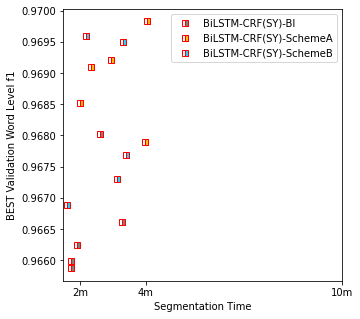

In [286]:
def marker(k):
    if "CNN" in k:
        return "o"
    elif "UniLSTM" in k:
        return "*"
    elif "BiLSTM" in k:
        return "s"
    
def markercolor(k):
    if "SY" in k:
        if "SchemeA" in k:
            return "#FDB90A"
        elif "SchemeB" in k:
            return "#25CFFF"
        elif "CBOW" in k:
            return "red"
        elif "Skipgram" in k:
            return "blue"
        else: 
            return "gray"
    else:
        return "white"
    
def plot_hyperopt(families, n=10):
    plt.figure(figsize=(5, 5))
    # draw max line
    for k in families:
        print(data[k]["path"])
        df = pd.read_csv(data[k]["path"]).sort_values(by="best-val:word_level:f1", ascending=False)[:n]
        
        best_model = df[df["best-val:word_level:f1"] == df["best-val:word_level:f1"].max()].to_dict("row")[0]
        print(f"--😎 {k}")

        print(best_model["name"], "size=%d" % best_model["num_trainable_params"])
        print("Val WL-F1=%.4f" % best_model["best-val:word_level:f1"], best_model["best-val:model_path"])
        print("  min=%.4f" % df["best-val:word_level:f1"].min(), " | ", "max=%.4f" % df["best-val:word_level:f1"].max() )
        print(
            "TEST: CL-f1=%.4f" % best_model["best-test:char_level:f1"],
            "WL-f1=%.4f" % best_model["best-test:word_level:f1"],
            "⚠️ AVG TEST: WL-f1=%.4f±%.4f" % (df["best-test:word_level:f1"].mean(), df["best-test:word_level:f1"].std()) 
        )

        print(best_model["params"], "lr=%.2e"%best_model["lr"], "weight_decay=%.2e" % best_model["weight_decay"],)
        print("avg traiing", df["training_took"].mean()/60)
        plt.plot(
            df["best-val:time_took"] / 60 , df["best-val:word_level:f1"],
            lw=0,
            label=k,
            marker=marker(k),
            markeredgecolor="red" if "CRF" in k else "black",
            markerfacecolor=markercolor(k),
#             "gray" if "SY" in k else "white",
            fillstyle="right" if "(SY)" in k else "full",
            markerfacecoloralt="white"
        )

    plt.ylabel("BEST Validation Word Level f1")
    plt.xlabel("Segmentation Time")
    plt.xticks([2, 4, 10], ["2m", "4m", "10m"])
    
    plt.legend()
    
plot_hyperopt([
    "BiLSTM-CRF(SY)-BI",
    "BiLSTM-CRF(SY)-SchemeA",
    "BiLSTM-CRF(SY)-SchemeB",
], n=5)

./stats/seq_sy_lstm_bi.yaml-2020-06-02--15-23.20.csv
--😎 BiLSTM(SY)-BI
seq_sy_lstm size=1429613
Val WL-F1=0.9697 ./artifacts/seq_sy_lstm_bi.yaml-2020-06-02--15-23.20/run-5
  min=0.9664  |  max=0.9697
TEST: CL-f1=0.9780 WL-f1=0.9533 ⚠️ AVG TEST: WL-f1=0.9504±0.0020
bi:1|cells:240|crf:0|do:0.034565166404976644|embs:64|l1:25|oc:BI lr=8.22e-04 weight_decay=8.76e-04
avg traiing 19.630993183453878
./stats/seq_sy_lstm_scheme_a.yaml-2020-06-02--15-23.20.csv
--😎 BiLSTM(SY)-SchemeA
seq_sy_lstm size=2342758
Val WL-F1=0.9679 ./artifacts/seq_sy_lstm_scheme_a.yaml-2020-06-02--15-23.20/run-4
  min=0.9665  |  max=0.9679
TEST: CL-f1=0.9773 WL-f1=0.9512 ⚠️ AVG TEST: WL-f1=0.9508±0.0007
bi:1|cells:401|crf:0|do:0.07015180476486971|embs:64|l1:18|oc:SchemeASyLevel lr=4.87e-04 weight_decay=8.87e-04
avg traiing 23.563945427735646
./stats/seq_sy_lstm_scheme_b.yaml-2020-06-02--15-23.20.csv
--😎 BiLSTM(SY)-SchemeB
seq_sy_lstm size=1554382
Val WL-F1=0.9668 ./artifacts/seq_sy_lstm_scheme_b.yaml-2020-06-02--15-23.20

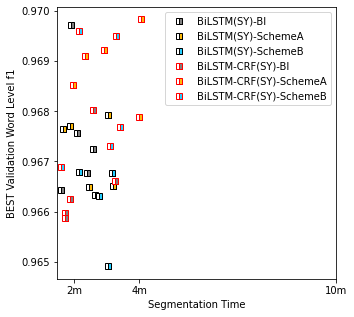

In [335]:
plot_hyperopt([
    "BiLSTM(SY)-BI",
    "BiLSTM(SY)-SchemeA",
    "BiLSTM(SY)-SchemeB",
    "BiLSTM-CRF(SY)-BI",
    "BiLSTM-CRF(SY)-SchemeA",
    "BiLSTM-CRF(SY)-SchemeB",
], n=5)

./stats/seq_ch_lstm_bi.yaml-2020-06-03--08-10.20.csv
--😎 BiLSTM(CH)-BI
seq_ch_lstm size=2036413
Val WL-F1=0.9657 ./artifacts/seq_ch_lstm_bi.yaml-2020-06-03--08-10.20/run-12
  min=0.9641  |  max=0.9657
TEST: CL-f1=0.9744 WL-f1=0.9436 ⚠️ AVG TEST: WL-f1=0.9434±0.0008
bi:1|cells:467|do:0.3196381349646087|embc:32|embt:32|l1:43|oc:BI lr=4.82e-04 weight_decay=1.20e-06
avg traiing 113.37065919478734
./stats/seq_sy_ch_lstm_bi.yaml-2020-06-02--19-13.20.csv
--😎 BiLSTM(CH+SY)-BI
seq_sy_ch_lstm size=2079518
Val WL-F1=0.9711 ./artifacts/seq_sy_ch_lstm_bi.yaml-2020-06-02--19-13.20/run-2
  min=0.9701  |  max=0.9711
TEST: CL-f1=0.9785 WL-f1=0.9544 ⚠️ AVG TEST: WL-f1=0.9523±0.0013
bi:1|cells:331|crf:0|do:0.4454712746167098|embc:32|embs:64|embt:32|l1:36|oc:BI lr=5.84e-04 weight_decay=1.11e-04
avg traiing 103.592252480189


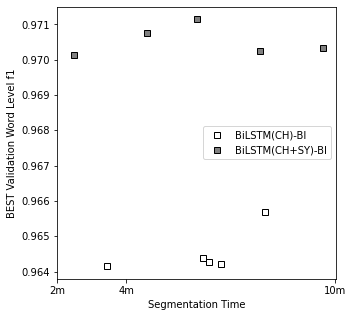

In [318]:
plot_hyperopt([
    "BiLSTM(CH)-BI",
    "BiLSTM(CH+SY)-BI",
], n=5)

./stats/seq_ch_conv_3lv.yaml-2020-06-03--12-11.20.csv
--😎 ID-CNN(CH)-BI
seq_ch_conv_3lv size=391291
Val WL-F1=0.9653 ./artifacts/seq_ch_conv_3lv.yaml-2020-06-03--12-11.20/run-8
  min=0.9634  |  max=0.9653
TEST: CL-f1=0.9739 WL-f1=0.9431 ⚠️ AVG TEST: WL-f1=0.9434±0.0004
conv:235|do:0.0008349951316932169|embc:32|embt:32|l1:39|oc:BI lr=3.88e-04 weight_decay=4.41e-04
avg traiing 113.96091842969258
./stats/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20.csv
--😎 ID-CNN(CH+SY)-BI
seq_sy_ch_conv_3lv size=1161791
Val WL-F1=0.9711 ./artifacts/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
  min=0.9702  |  max=0.9711
TEST: CL-f1=0.9780 WL-f1=0.9545 ⚠️ AVG TEST: WL-f1=0.9536±0.0008
conv:200|do:0.21668210079692052|embc:32|embs:64|embt:32|l1:47|oc:BI lr=9.20e-04 weight_decay=1.17e-05
avg traiing 83.03768361886343


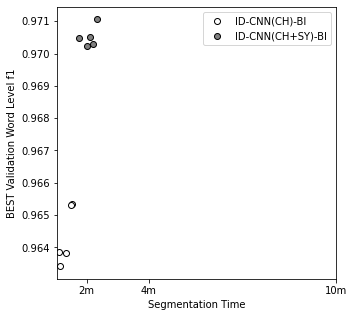

In [334]:
plot_hyperopt([
    "ID-CNN(CH)-BI",
    "ID-CNN(CH+SY)-BI",
], n=5)

./stats/seq_sy_conv_3lv.yaml-2020-06-02--08-19.20.csv
--😎 ID-CNN(SY)-BI
seq_sy_conv_3lv size=1136281
Val WL-F1=0.9706 ./artifacts/seq_sy_conv_3lv.yaml-2020-06-02--08-19.20/run-18
  min=0.9689  |  max=0.9706
TEST: CL-f1=0.9784 WL-f1=0.9543 ⚠️ AVG TEST: WL-f1=0.9530±0.0011
conv:208|do:0.23288288064838197|embs:64|l1:29|oc:BI lr=9.01e-04 weight_decay=2.27e-04
avg traiing 49.536540700594585
./stats/seq_sy_conv_3lv_scheme_a.yaml-2020-06-02--10-49.20.csv
--😎 ID-CNN(SY)-SchemeA
seq_sy_conv_3lv size=1136339
Val WL-F1=0.9702 ./artifacts/seq_sy_conv_3lv_scheme_a.yaml-2020-06-02--10-49.20/run-15
  min=0.9681  |  max=0.9702
TEST: CL-f1=0.9780 WL-f1=0.9531 ⚠️ AVG TEST: WL-f1=0.9523±0.0010
conv:207|do:0.36499381786170454|embs:64|l1:41|oc:SchemeASyLevel lr=7.02e-04 weight_decay=2.79e-04
avg traiing 51.64720451037089
./stats/seq_sy_conv_3lv_scheme_b.yaml-2020-06-02--10-49.20.csv
--😎 ID-CNN(SY)-SchemeB
seq_sy_conv_3lv size=1169615
Val WL-F1=0.9686 ./artifacts/seq_sy_conv_3lv_scheme_b.yaml-2020-06-02--10

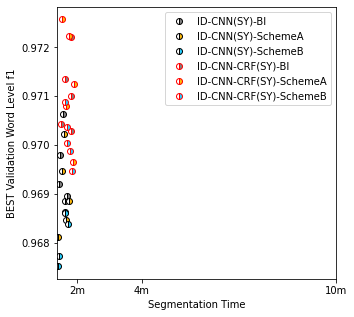

In [336]:
plot_hyperopt([
    "ID-CNN(SY)-BI",
    "ID-CNN(SY)-SchemeA",
    "ID-CNN(SY)-SchemeB",
    "ID-CNN-CRF(SY)-BI",
    "ID-CNN-CRF(SY)-SchemeA",
    "ID-CNN-CRF(SY)-SchemeB",
], n=5)

./stats/seq_sy_conv_3lv_crf_bi.yaml-2020-06-01--11-40.20.csv
--😎 ID-CNN-CRF(SY)-BI
seq_sy_conv_3lv size=1206435
Val WL-F1=0.9722 ./artifacts/seq_sy_conv_3lv_crf_bi.yaml-2020-06-01--11-40.20/run-12
TEST: CL-f1=0.9789 WL-f1=0.9563 ⚠️ AVG TEST: WL-f1=0.9548±0.0012
conv:232|crf:1|do:0.16956991381346276|embs:64|l1:35|oc:BI lr=9.67e-04 weight_decay=1.77e-04
avg traiing 157.46641794045766
./stats/seq_sy_conv_3lv_crf_scheme_a.yaml-2020-06-01--11-39.20.csv
--😎 ID-CNN-CRF(SY)-SchemeA
seq_sy_conv_3lv size=997375
Val WL-F1=0.9726 ./artifacts/seq_sy_conv_3lv_crf_scheme_a.yaml-2020-06-01--11-39.20/run-1
TEST: CL-f1=0.9788 WL-f1=0.9560 ⚠️ AVG TEST: WL-f1=0.9543±0.0014
conv:150|crf:1|do:0.16578140679250042|embs:64|l1:19|oc:SchemeASyLevel lr=8.55e-04 weight_decay=5.86e-04
avg traiing 159.5336995546023
./stats/seq_sy_conv_3lv_crf_scheme_b.yaml-2020-06-01--11-39.20.csv
--😎 ID-CNN-CRF(SY)-SchemeB
seq_sy_conv_3lv size=1092547
Val WL-F1=0.9709 ./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-2020-06-01--11-39.

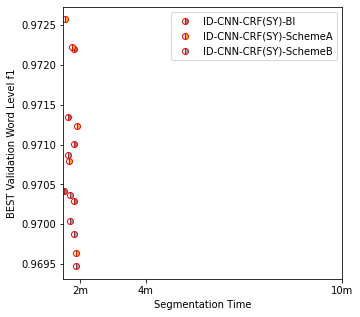

In [244]:
plot_hyperopt([
    "ID-CNN-CRF(SY)-BI",
    "ID-CNN-CRF(SY)-SchemeA",
    "ID-CNN-CRF(SY)-SchemeB",
], n=5)

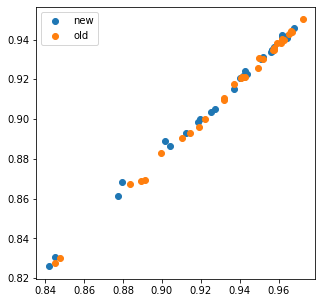

In [211]:
df_1 = pd.read_csv(data["DilatedCNN(CH+SY)"])
df_2 = pd.read_csv(data["DilatedCNN(CH+SY)-OLD"])
plt.figure(figsize=(5, 5))
plt.scatter(df_1["best-val:word_level:f1"], df_1["best-test:word_level:f1"], label="new")
plt.scatter(df_2["best-val:word_level:f1"], df_2["best-test:word_level:f1"], label="old")
plt.legend()

In [214]:
df = pd.read_csv("../stats/seq_sy_ch_conv_3lv.yaml-2020-05-29--09-51.10.csv")

In [215]:
df["best-test:word_level:f1"]

0    0.949265
1    0.866162
2    0.903786
3    0.924043
4    0.892370
5    0.909790
6    0.915886
7    0.936461
8    0.914691
9    0.895153
Name: best-test:word_level:f1, dtype: float64

In [221]:
df[df["best-test:word_level:f1"] == df["best-test:word_level:f1"].max()]["best-test:model_path"].values

array(['./artifacts/seq_sy_ch_conv_3lv.yaml-2020-05-29--09-51.10/run-7'],
      dtype=object)

In [206]:
df_["best-test:word_level:f1"].max()

0.9459547570318584

----
seq_sy_ch_conv_3lv size=574875
Val WL-F1=0.9723 ./artifacts/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30/run-13
TEST: CL-f1=0.9800 WL-f1=0.9501 ⚠️ AVG TEST: WL-f1=0.9408±0.0046
conv:137|do:0.0929509300900459|embc:32|embs:64|embt:32|l1:42|oc:BI lr=4.65e-04 weight_decay=1.06e-06
avg traiing 62.082446708281836
----
seq_sy_ch_conv_3lv size=665543
Val WL-F1=0.9697 ./artifacts/seq_sy_ch_conv_3lv_scheme_a.yaml-2020-05-24--17-49.30/run-24
TEST: CL-f1=0.9793 WL-f1=0.9484 ⚠️ AVG TEST: WL-f1=0.9379±0.0042
conv:177|do:0.11905739983075092|embc:32|embs:64|embt:32|l1:31|oc:SchemeA lr=9.36e-04 weight_decay=4.60e-05
avg traiing 58.39501771688461
----
seq_sy_ch_conv_3lv size=568682
Val WL-F1=0.9636 ./artifacts/seq_sy_ch_conv_3lv_scheme_b.yaml-2020-05-24--17-49.30/run-3
TEST: CL-f1=0.9774 WL-f1=0.9440 ⚠️ AVG TEST: WL-f1=0.9353±0.0053
conv:134|do:0.06434694298847987|embc:32|embs:64|embt:32|l1:40|oc:SchemeB lr=2.25e-04 weight_decay=2.69e-05
avg traiing 50.11373278776805
----
seq_sy_ch_lstm size=120989

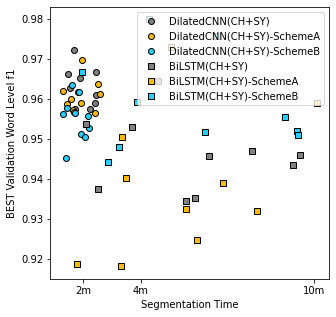

In [175]:
plot_hyperopt([
    "DilatedCNN(CH+SY)",
    "DilatedCNN(CH+SY)-SchemeA",
    "DilatedCNN(CH+SY)-SchemeB",
    "BiLSTM(CH+SY)",
    "BiLSTM(CH+SY)-SchemeA",
    "BiLSTM(CH+SY)-SchemeB",
], n=10)

----
seq_sy_ch_conv_3lv size=574875
Val WL-F1=0.9723 ./artifacts/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30/run-13
TEST: CL-f1=0.9800 WL-f1=0.9501 ⚠️ AVG TEST: WL-f1=0.9442±0.0038
conv:137|do:0.0929509300900459|embc:32|embs:64|embt:32|l1:42|oc:BI lr=4.65e-04 weight_decay=1.06e-06
avg traiing 52.203595696290336
----
seq_sy_ch_conv_3lv size=770683
Val WL-F1=0.9550 ./artifacts/seq_sy_ch_conv_3lv_crf.yaml-2020-05-26--23-01.10/run-4
TEST: CL-f1=0.9721 WL-f1=0.9314 ⚠️ AVG TEST: WL-f1=0.8933±0.0332
conv:215|crf:1|do:0.06726981476217642|embc:32|embs:64|embt:32|l1:31|oc:BI lr=1.42e-05 weight_decay=3.80e-05
avg traiing 963.0968658161163
----
seq_sy_ch_lstm size=1209891
Val WL-F1=0.9645 ./artifacts/seq_sy_ch_lstm_bi.yaml-2020-05-22--22-42.30/run-19
TEST: CL-f1=0.9754 WL-f1=0.9362 ⚠️ AVG TEST: WL-f1=0.9306±0.0051
bi:1|cells:257|do:0.0543880159114884|embc:32|embs:64|embt:32|l1:21|oc:BI lr=7.86e-05 weight_decay=1.78e-06
avg traiing 103.6668461139997
----
seq_sy_ch_lstm size=842019
Val WL-F1=0.9552

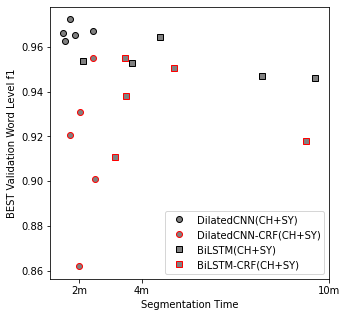

In [176]:
plot_hyperopt([
    "DilatedCNN(CH+SY)",
    "DilatedCNN-CRF(CH+SY)",
    "BiLSTM(CH+SY)",
    "BiLSTM-CRF(CH+SY)",
], n=5)

----
seq_sy_conv_3lv size=520678
Val WL-F1=0.9555 ./artifacts/seq_sy_conv_3lv.yaml-2020-05-25--20-43.30/run-28
TEST: CL-f1=0.9715 WL-f1=0.9304 ⚠️ AVG TEST: WL-f1=0.9294±0.0018
conv:126|do:0.1292870335308165|embs:64|l1:18|oc:BI lr=6.15e-04 weight_decay=8.84e-05
avg traiing 24.53267930905024
----
seq_sy_conv_3lv size=792293
Val WL-F1=0.9514 ./artifacts/seq_sy_conv_3lv_scheme_a.yaml-2020-05-27--17-16.30/run-8
TEST: CL-f1=0.9711 WL-f1=0.9285 ⚠️ AVG TEST: WL-f1=0.9211±0.0052
conv:239|do:0.08208699370477629|embs:64|l1:18|oc:SchemeA lr=5.35e-04 weight_decay=3.65e-06
avg traiing 28.248124356269837
----
seq_sy_conv_3lv size=461960
Val WL-F1=0.8632 ./artifacts/seq_sy_conv_3lv_crf_scheme_a.yaml-2020-05-27--23-33.10/run-6
TEST: CL-f1=0.9205 WL-f1=0.8462 ⚠️ AVG TEST: WL-f1=0.8342±0.0193
conv:86|crf:1|do:0.17369164816260702|embs:64|l1:24|oc:SchemeA lr=7.36e-04 weight_decay=6.33e-04
avg traiing 345.3543784483274
----
seq_sy_conv_3lv size=604534
Val WL-F1=0.9559 ./artifacts/seq_sy_conv_3lv_scheme_b.ya

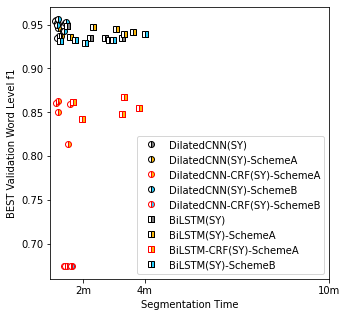

In [187]:
plot_hyperopt([
    "DilatedCNN(SY)",
    "DilatedCNN(SY)-SchemeA",
    "DilatedCNN-CRF(SY)-SchemeA",
    "DilatedCNN(SY)-SchemeB",
    "DilatedCNN-CRF(SY)-SchemeB",
    "BiLSTM(SY)",
    "BiLSTM(SY)-SchemeA",
    "BiLSTM-CRF(SY)-SchemeA",
    "BiLSTM(SY)-SchemeB",
], n=5)

In [184]:
dd = pd.read_csv(data["DilatedCNN-CRF(SY)-SchemeB"])

In [185]:
dd

,epoch,lr,name,num_trainable_params,params,training_took,weight_decay,best-val:char_level:tp,best-val:char_level:fp,best-val:char_level:tn,...,best-test:word_level:total_words_in_sample,best-test:word_level:total_words_in_ref_sample,best-test:char_level:precision,best-test:char_level:recall,best-test:char_level:f1,best-test:word_level:precision,best-test:word_level:recall,best-test:word_level:f1,best-test:time_took,best-test:model_path
0,20,0.000027,seq_sy_conv_3lv,817463,conv:245|crf:1|do:0.33828826128374656|embs:64|...,22476.610754,0.000048,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,23.995411,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
1,20,0.000032,seq_sy_conv_3lv,662347,conv:191|crf:1|do:0.0929548373225999|embs:64|l...,20885.841338,0.000006,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,20.792163,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
2,20,0.000004,seq_sy_conv_3lv,590919,conv:162|crf:1|do:0.03887544645850505|embs:64|...,20567.371020,0.000238,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,19.732983,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
3,20,0.000189,seq_sy_conv_3lv,632219,conv:178|crf:1|do:0.283540536637743|embs:64|l1...,20416.618798,0.000005,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,20.172639,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
4,20,0.000001,seq_sy_conv_3lv,790571,conv:238|crf:1|do:0.25973783460429384|embs:64|...,21286.633058,0.000151,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,23.386642,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
5,20,0.000301,seq_sy_conv_3lv,632219,conv:178|crf:1|do:0.3055563794175505|embs:64|l...,20728.488163,0.000111,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,20.264292,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
6,20,0.000003,seq_sy_conv_3lv,603091,conv:167|crf:1|do:0.058206047958351936|embs:64...,20419.925475,0.000002,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,19.561182,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
7,20,0.000001,seq_sy_conv_3lv,465053,conv:88|crf:1|do:0.32210753231942996|embs:64|l...,19873.303503,0.000690,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,16.361878,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
8,20,0.000304,seq_sy_conv_3lv,506597,conv:116|crf:1|do:0.42226883323979697|embs:64|...,19933.934062,0.000045,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,17.465565,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...
9,20,0.000286,seq_sy_conv_3lv,446219,conv:73|crf:1|do:0.18045211449270543|embs:64|l...,19369.421977,0.000006,495595.0,144902.0,1353525.0,...,141014.0,109280.0,0.760917,0.981881,0.857392,0.583715,0.753221,0.657723,16.265370,./artifacts/seq_sy_conv_3lv_crf_scheme_b.yaml-...


# Expected Performance

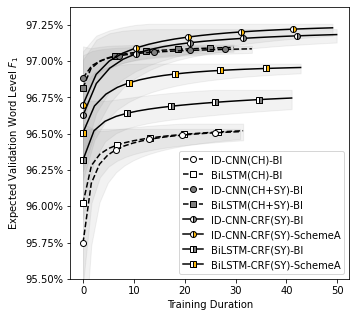

In [344]:
def plot_expected_perf(families, xticks):
    plt.figure(figsize=(5, 5))
#     plt.axvline(8, ls="--", zorder=0, color="black", lw=1)
#     plt.axvline(26, ls="--", zorder=0, color="black", lw=1)
    for k in families:
        df = pd.read_csv(data[k]["path"])
        exp_perf = expected_max_performance.samplemax(df["best-val:word_level:f1"] * 100)
        mean = np.array(exp_perf["mean"])
        std = np.array(exp_perf["var"])
        _min, _max = exp_perf["min"], exp_perf["max"]
        avg_time = (df["training_took"] / (60*60)).mean()
        x = np.arange(0, df.shape[0]) * avg_time
        plt.plot(
            x, 
            exp_perf["mean"] ,
            marker=marker(k), 
            ls="-" if "CRF" in k else "--",
            label=k,
            markevery=4,
            markerfacecolor=markercolor(k),
            color="black",
            zorder=1 if "CNN" in k else 0,
            fillstyle="right" if "(SY)" in k else "full",
            markerfacecoloralt="white"
        )
        
        plt.fill_between(
            x,
            np.where(mean - std > _min, mean - std, _min),
            np.where(mean + std < _max, mean + std, _max),
            color="gray",
            alpha=0.1,
            zorder=0,
        )
    plt.ylim(95.5)
    plt.ylabel("Expected Validation Word Level ${F_1}$")
    plt.xlabel("Training Duration")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=2))

    if len(xticks) > 0:
        
        plt.xticks(*xticks)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    
# plot_expected_perf([
#     "DilatedCNN(CH)",
#     "DilatedCNN(SY)",
#     "DilatedCNN(CH+SY)",
# #     "DilatedCNN(CH+SY-CBOW)",
# #     "DilatedCNN(CH+SY-Skipgram)",
#     "DilatedCNN(CH+SY)-SchemeA",
#     "DilatedCNN(CH+SY)-SchemeB",
#     "BiLSTM(CH)",
#     "BiLSTM(SY)",
#     "BiLSTM(CH+SY)",
#     "BiLSTM(CH+SY)-SchemeA",
#     "BiLSTM(CH+SY)-SchemeB",
# ], xticks=([8, 12, 24, 48], ["8h", "12h", "1d", "2d"]))

plot_expected_perf([

    "ID-CNN(CH)-BI",
    "BiLSTM(CH)-BI",
#     "ID-CNN(SY)-SchemeA",
#     "ID-CNN(SY)-SchemeB",

    "ID-CNN(CH+SY)-BI",
    "BiLSTM(CH+SY)-BI",
    "ID-CNN-CRF(SY)-BI",
    "ID-CNN-CRF(SY)-SchemeA",
#     "ID-CNN-CRF(SY)-SchemeB",
    
#     "BiLSTM(SY)-BI",
#     "BiLSTM(SY)-SchemeA",
#     "BiLSTM(SY)-SchemeB",
    
    "BiLSTM-CRF(SY)-BI",
    "BiLSTM-CRF(SY)-SchemeA",
#     "BiLSTM-CRF(SY)-SchemeB",
], xticks=())



# plt.savefig("./figures/expected_val_perf.png", dpi=300)

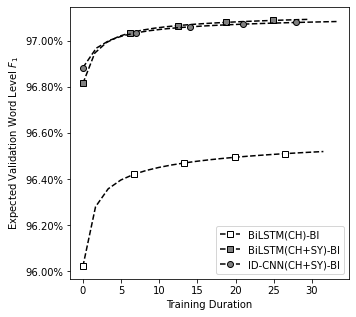

In [331]:
plot_expected_perf([
#     "ID-CNN(CH)-BI",
    "BiLSTM(CH)-BI",
    "BiLSTM(CH+SY)-BI",
    "ID-CNN(CH+SY)-BI",    
], xticks=())




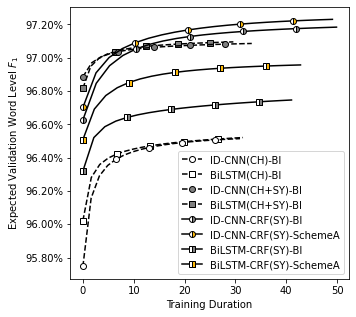

## Schema A and B models

----
seq_sy_ch_conv_3lv size=574875
Val WL-F1=0.9723 ./artifacts/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30/run-13
TEST: CL-f1=0.9800 WL-f1=0.9501 ⚠️ AVG TEST: WL-f1=0.9408±0.0046
conv:137|do:0.0929509300900459|embc:32|embs:64|embt:32|l1:42|oc:BI lr=4.65e-04 weight_decay=1.06e-06
avg traiing 62.082446708281836
----
seq_sy_ch_conv_3lv size=665543
Val WL-F1=0.9697 ./artifacts/seq_sy_ch_conv_3lv_scheme_a.yaml-2020-05-24--17-49.30/run-24
TEST: CL-f1=0.9793 WL-f1=0.9484 ⚠️ AVG TEST: WL-f1=0.9379±0.0042
conv:177|do:0.11905739983075092|embc:32|embs:64|embt:32|l1:31|oc:SchemeA lr=9.36e-04 weight_decay=4.60e-05
avg traiing 58.39501771688461
----
seq_sy_ch_conv_3lv size=568682
Val WL-F1=0.9636 ./artifacts/seq_sy_ch_conv_3lv_scheme_b.yaml-2020-05-24--17-49.30/run-3
TEST: CL-f1=0.9774 WL-f1=0.9440 ⚠️ AVG TEST: WL-f1=0.9353±0.0053
conv:134|do:0.06434694298847987|embc:32|embs:64|embt:32|l1:40|oc:SchemeB lr=2.25e-04 weight_decay=2.69e-05
avg traiing 50.11373278776805
----
seq_sy_ch_lstm size=120989

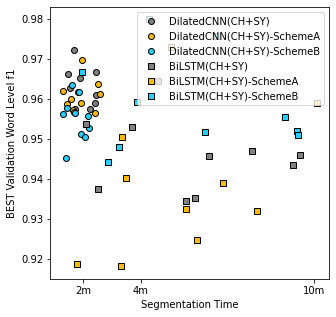

In [39]:
df_ = pd.read_csv(data["DilatedCNN(CH+SY)"])
df_a = pd.read_csv(data["DilatedCNN(CH+SY)-SchemeA"])

In [40]:
from scipy import stats

In [271]:
col = "best-test:word_level:f1"

def ttest(d1, d2, plot=False):
    print('------')
    print(f"t-test({d1}, {d2})")
    
    df_ = pd.read_csv(data[d1]["path"])
    df_a = pd.read_csv(data[d2]["path"])
    if plot:
        plt.hist(df_[col], label=d1, alpha=0.8, bins=5)
        plt.hist(df_a[col], label=d2, alpha=0.8, bins=5)
        plt.legend()
    res = stats.ttest_ind(df_[col], df_a[col], equal_var=False)
    print(res)
    if res.pvalue < 0.05:
        print("H0: two model families perform equally well (means of WL-F1 are the same, and variance isn't assumed to be equal)")
        print("⚠️Reject H0: there is significant evidence that the means of WL-F1 from the two models are significantly different.")
        print(f"pvalue={res.pvalue} < 0.5")
        
# ttest("BiLSTM(CH+SY)", "DilatedCNN(CH+SY)")
# ttest("DilatedCNN(CH+SY)", "DilatedCNN(SY)")

ttest("ID-CNN-CRF(SY)-BI", "ID-CNN-CRF(SY)-SchemeA")
ttest("ID-CNN-CRF(SY)-SchemeA", "ID-CNN-CRF(SY)-SchemeB")

ttest("BiLSTM-CRF(SY)-BI", "BiLSTM-CRF(SY)-SchemeA")
ttest("BiLSTM-CRF(SY)-SchemeA", "BiLSTM-CRF(SY)-SchemeB")

# ttest("DilatedCNN(CH+SY)", "DilatedCNN(CH+SY)-SchemeB")
# ttest("DilatedCNN(CH+SY)-SchemeA", "DilatedCNN(CH+SY)-SchemeB")

# ttest("DilatedCNN(SY)", "DilatedCNN(SY)-SchemeA")
# ttest("DilatedCNN(SY)", "DilatedCNN(SY)-SchemeB")
# ttest("DilatedCNN(SY)-SchemeA", "DilatedCNN(SY)-SchemeB")

# ttest("BiLSTM(CH+SY)", "BiLSTM(CH)")
# ttest("BiLSTM(CH+SY)", "BiLSTM(SY)")
# ttest("BiLSTM(CH+SY)-SchemeB", "BiLSTM(SY)")
# ttest("BiLSTM(CH+SY)", "BiLSTM(CH+SY)-SchemeA")
# ttest("BiLSTM(CH+SY)", "BiLSTM(CH+SY)-SchemeB")
# ttest("BiLSTM(SY)", "BiLSTM(SY)-SchemeA")
# ttest("BiLSTM(SY)", "BiLSTM(SY)-SchemeB")
# ttest("BiLSTM(SY)-SchemeA", "BiLSTM(SY)-SchemeB")

------
t-test(ID-CNN-CRF(SY)-BI, ID-CNN-CRF(SY)-SchemeA)
Ttest_indResult(statistic=-0.12752277258747288, pvalue=0.8992082545092323)
------
t-test(ID-CNN-CRF(SY)-SchemeA, ID-CNN-CRF(SY)-SchemeB)
Ttest_indResult(statistic=-0.20767427973600244, pvalue=0.8365942500833726)
------
t-test(BiLSTM-CRF(SY)-BI, BiLSTM-CRF(SY)-SchemeA)
Ttest_indResult(statistic=-1.2660876159940784, pvalue=0.2133129482554061)
------
t-test(BiLSTM-CRF(SY)-SchemeA, BiLSTM-CRF(SY)-SchemeB)
Ttest_indResult(statistic=-0.4512704243303022, pvalue=0.6545051130583025)
